In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import cvxpy as cp

# Exercise 1

In [4]:
# Graph creation
G1 = nx.DiGraph()
G1.add_edges_from([
    ('o', 'a', {'capacity':3, 'key':'e1'}),
    ('o', 'b', {'capacity':3, 'key':'e3'}),
    ('a', 'b', {'capacity':1, 'key':'e6'}),
    ('b', 'c', {'capacity':3, 'key':'e4'}),
    ('a', 'd', {'capacity':3, 'key':'e2'}),
    ('c', 'd', {'capacity':2, 'key':'e5'})
])


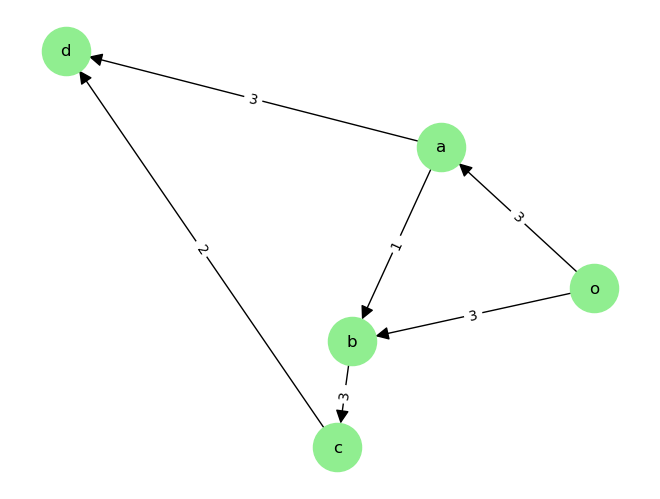

<Figure size 800x500 with 0 Axes>

In [5]:
pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=True, node_color='lightgreen', node_size=1200, arrows = True, arrowsize=20)

edge_labels = nx.get_edge_attributes(G1, 'capacity')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.figure(figsize=(8, 5))
plt.show()

### (a) checking what we've done manually with networkx functions

In [6]:
#finding the minimum cut
nx.algorithms.flow.minimum_cut(G1,'o','d')

(5, ({'a', 'b', 'c', 'o'}, {'d'}))

In [7]:
#finding the maximum flow
nx.algorithms.flow.maximum_flow(G1,'o','d')

(5,
 {'o': {'a': 3, 'b': 2},
  'a': {'b': 0, 'd': 3},
  'b': {'c': 2},
  'c': {'d': 2},
  'd': {}})

### (b)

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def compute_optimal_flow_increase(G_base, X_max):
    source = 'o'
    sink = 'd'
    all_edges = list(G_base.edges())

    # --- Lists to store results ---
    x_values = list(range(X_max + 1))
    f_x_values = []
    optimal_distributions = []

    # --- State variables ---
    G_current = G_base.copy() 
    # current_dist tracks the total added capacity for each edge
    current_dist = {edge: 0 for edge in all_edges}

    # CALCULATE f(0)

    flow_x0 = nx.maximum_flow_value(G_current, source, sink, capacity='capacity')
    f_x_values.append(flow_x0)
    optimal_distributions.append(current_dist.copy())
    
    print(f"x=0, Max Flow: {flow_x0}, distribution: {current_dist}")

    
    # ITERATIVE LOOP (x = 1 to X_max)

    for x in x_values[1:]:
        
        # Start with the flow from the previous step
        best_new_flow = f_x_values[-1] 
        best_edge_to_augment = None

        # --- Find the best edge to add 1 unit to ---
        for edge in all_edges:
            u, v = edge
            
            # Create a temporary graph based on the current state
            G_temp = G_current.copy()
            
            # Add 1 unit of capacity to this single edge
            G_temp[u][v]['capacity'] += 1
            
            # Calculate the potential new flow
            current_flow = nx.maximum_flow_value(G_temp, source, sink, capacity='capacity')
            
            # If this is the best flow found so far, save it
            if current_flow > best_new_flow:
                best_new_flow = current_flow
                best_edge_to_augment = edge


        # If no edge improved the flow, best_edge_to_augment will be None
        # We handle this by picking the first edge (as the flow won't increase)
        if best_edge_to_augment is None:
            best_edge_to_augment = all_edges[0]

        # Update G_current for the next iteration
        u_best, v_best = best_edge_to_augment
        G_current[u_best][v_best]['capacity'] += 1
        
        # Update the distribution map
        current_dist[best_edge_to_augment] += 1
        
        # Store the results for this value of x
        f_x_values.append(best_new_flow)
        optimal_distributions.append(current_dist.copy())
        
        print(f"x={x}, Max Flow: {best_new_flow}, Edge Added: {best_edge_to_augment}")

    # 4. RESULTS
    return x_values, f_x_values, optimal_distributions

def format_results_as_table(x_values, f_x_values, optimal_distributions):
    """Helper function to format the results in a pandas DataFrame."""
    df_data = []
    for i in range(len(x_values)):
        dist = optimal_distributions[i]
        row = {
            'x': x_values[i],
            'Max Flow f(x)': f_x_values[i],
            'delta(o,a)': dist.get(('o', 'a'), 0),
            'delta(o,b)': dist.get(('o', 'b'), 0),
            'delta(a,b)': dist.get(('a', 'b'), 0),
            'delta(b,c)': dist.get(('b', 'c'), 0),
            'delta(a,d)': dist.get(('a', 'd'), 0),
            'delta(c,d)': dist.get(('c', 'd'), 0)
        }
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    # Set 'x' as the index for cleaner printing
    df.set_index('x', inplace=True)
    return df

def plot_results(x_values, f_x_values):
    """Helper function to plot f(x) vs x."""
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, f_x_values, marker='o', linestyle='-')
    plt.title('Maximum Throughput $f(x)$ function of extra capacity $x$', fontsize=16)
    plt.xlabel('Extra capacity units ($x$)', fontsize=14)
    plt.ylabel('Maximum throughput $f(x)$', fontsize=14)
    plt.xticks(x_values)
    plt.yticks(sorted(list(set(f_x_values)))) # Clean y-axis
    plt.grid(True, linestyle='--')
    plt.show()


x=0, Max Flow: 5, distribution: {('o', 'a'): 0, ('o', 'b'): 0, ('a', 'b'): 0, ('a', 'd'): 0, ('b', 'c'): 0, ('c', 'd'): 0}
x=1, Max Flow: 6, Edge Added: ('c', 'd')
x=2, Max Flow: 6, Edge Added: ('o', 'a')
x=3, Max Flow: 7, Edge Added: ('a', 'd')
x=4, Max Flow: 7, Edge Added: ('o', 'a')
x=5, Max Flow: 8, Edge Added: ('a', 'd')
x=6, Max Flow: 8, Edge Added: ('o', 'a')
x=7, Max Flow: 9, Edge Added: ('a', 'd')
x=8, Max Flow: 9, Edge Added: ('o', 'a')
x=9, Max Flow: 10, Edge Added: ('a', 'd')
x=10, Max Flow: 10, Edge Added: ('o', 'a')
x=11, Max Flow: 11, Edge Added: ('a', 'd')
x=12, Max Flow: 11, Edge Added: ('o', 'a')
x=13, Max Flow: 12, Edge Added: ('a', 'd')
x=14, Max Flow: 12, Edge Added: ('o', 'a')
x=15, Max Flow: 13, Edge Added: ('a', 'd')
x=16, Max Flow: 13, Edge Added: ('o', 'a')
x=17, Max Flow: 14, Edge Added: ('a', 'd')
x=18, Max Flow: 14, Edge Added: ('o', 'a')
x=19, Max Flow: 15, Edge Added: ('a', 'd')
x=20, Max Flow: 15, Edge Added: ('o', 'a')
x=21, Max Flow: 16, Edge Added: ('

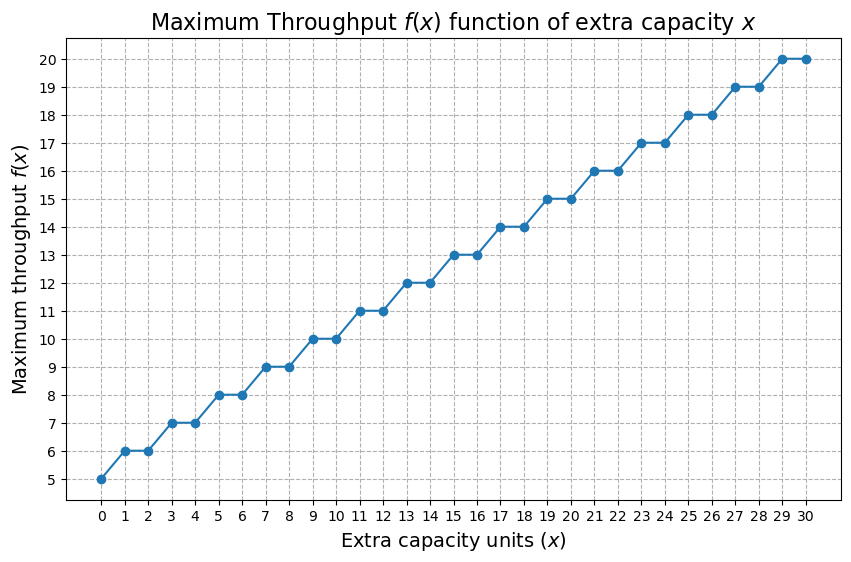

In [9]:
#Run the computation
X_max = 30
x_vals, flow_vals, dists = compute_optimal_flow_increase(G1, X_max)

#Print the result table
results_df = format_results_as_table(x_vals, flow_vals, dists)
print("\n--- Summary Table ---")
print(results_df)

#Plot the results
plot_results(x_vals, flow_vals)

### (c)

x=0, Max Flow: 6, distribution: {('o', 'a'): 0, ('o', 'b'): 0, ('o', 'd'): 0, ('a', 'b'): 0, ('a', 'd'): 0, ('b', 'c'): 0, ('c', 'd'): 0}
x=1, Max Flow: 7, Edge Added: ('o', 'd')
x=2, Max Flow: 8, Edge Added: ('o', 'd')
x=3, Max Flow: 9, Edge Added: ('o', 'd')
x=4, Max Flow: 10, Edge Added: ('o', 'd')
x=5, Max Flow: 11, Edge Added: ('o', 'd')
x=6, Max Flow: 12, Edge Added: ('o', 'd')
x=7, Max Flow: 13, Edge Added: ('o', 'd')
x=8, Max Flow: 14, Edge Added: ('o', 'd')
x=9, Max Flow: 15, Edge Added: ('o', 'd')
x=10, Max Flow: 16, Edge Added: ('o', 'd')
x=11, Max Flow: 17, Edge Added: ('o', 'd')
x=12, Max Flow: 18, Edge Added: ('o', 'd')
x=13, Max Flow: 19, Edge Added: ('o', 'd')
x=14, Max Flow: 20, Edge Added: ('o', 'd')
x=15, Max Flow: 21, Edge Added: ('o', 'd')
x=16, Max Flow: 22, Edge Added: ('o', 'd')
x=17, Max Flow: 23, Edge Added: ('o', 'd')
x=18, Max Flow: 24, Edge Added: ('o', 'd')
x=19, Max Flow: 25, Edge Added: ('o', 'd')
x=20, Max Flow: 26, Edge Added: ('o', 'd')
x=21, Max Flow

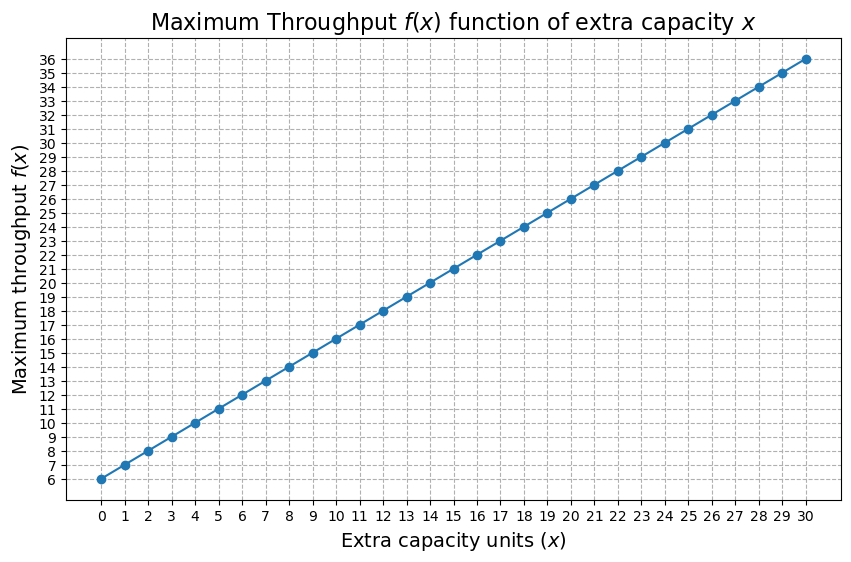

In [10]:
G1.add_edge('o', 'd', capacity=1)

#Run the computation
x_vals, flow_vals, dists = compute_optimal_flow_increase(G1, X_max=30)

#Format and print the table
results_df = format_results_as_table(x_vals, flow_vals, dists)
print("\n--- Summary Table ---")
print(results_df)

#Plot the results
plot_results(x_vals, flow_vals)

# Exercise 2

In [18]:
# Graph creation
n = 6

G_1 = nx.complete_graph(n)
mapping = {i: i + 1 for i in range(n)}
G_1 = nx.relabel_nodes(G_1, mapping)
G_1.add_edge(6, 15)

G_2 = nx.Graph()
G_2.add_edges_from([
    (7, 8), 
    (8, 9), 
    (9, 10),
    (9, 11),
    (9, 12),
    (9, 13),
    (9, 14)
])

pos = {
    1 : (2.0, -0.4),
    2: (3, -0.4),
    3: (3.5, 0.0),
    4: (3, 0.4),
    5: (2.0, 0.4),
    6: (1.5, 0.0),
    7: (1.0, 0.0),
    8: (0.5, 0.0),
    9: (0.0, 0.0),
    10: (0.0, 0.5),
    11: (-0.4, 0.3),
    12: (-0.6, 0.0),
    13: (-0.4, -0.3),
    14: (0.0, -0.5),
    15: (1.0, 0.5)
}

# Combining graphs
G2 = nx.compose(G_1, G_2)
G2.add_edge(6, 7)

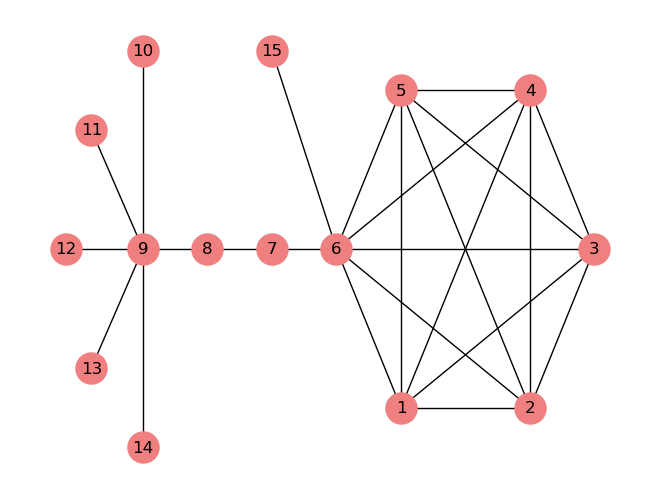

In [19]:
nx.draw(G2, pos, with_labels=True, node_color='lightcoral', node_size=500)
plt.show()

### (a)

In [20]:
# compute matrices of the graph
W = nx.adjacency_matrix(G2)
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

In [ ]:
N = G2.number_of_nodes() 
beta = 0.15
mu = np.ones((N,1))

# compute the largest eigenvalue of W ( real thanks to Perron-Frobenius theorem)
w,v = np.linalg.eig(W)
w = w.real

lambda_max = max(w) 
zk = np.linalg.inv(np.diag(np.ones(N)) - W.T*(1-beta)/lambda_max) * beta @ mu

# normalize the centrality
zk = zk/sum(zk)

print("Katz centrality: \n", zk)

Katz centrality: 
 [[0.11813975]
 [0.11813975]
 [0.11813975]
 [0.11813975]
 [0.11813975]
 [0.13008034]
 [0.03893046]
 [0.04424717]
 [0.0317192 ]
 [0.04281112]
 [0.02430259]
 [0.02430259]
 [0.02430259]
 [0.02430259]
 [0.02430259]]


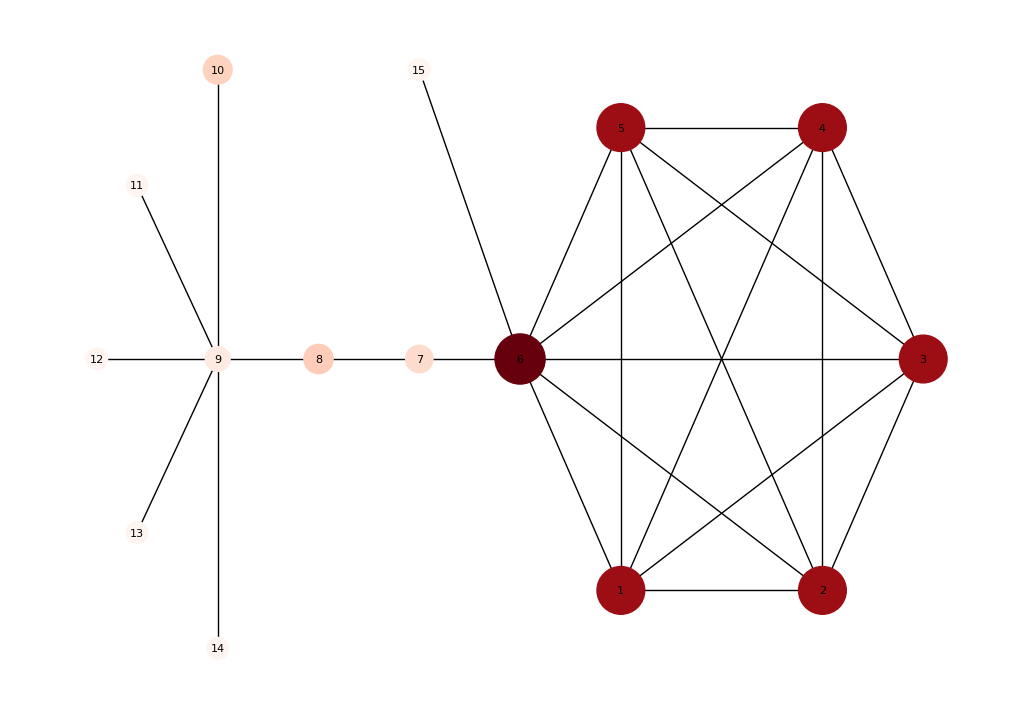

In [22]:
plt.figure(1, figsize=(10,7))
nx.draw(G2,
        pos,
        with_labels=True,
        nodelist=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
        # node size is proportional to eigenvector centrality
        node_size = [d*10000 for d in list(zk)],  
        node_color=list(zk),
        font_size=8,
        cmap=plt.cm.Reds,
        )
plt.show()

### (b)  
$$
z = (\mathbf{I} - (1-\beta) P')^{-1} \beta \mu
$$

In [23]:
zb = np.linalg.inv(np.diag(np.ones(N)) - P.T*(1-beta)) * beta @ mu
zb = zb/sum(zb)

# transform centralities to float
val = []
for i in zb:
    val.append(float(i))

zb_list = val

zip_iterator = zip(G2.nodes(), zb_list)
zb_dict = dict(zip_iterator)

print("Bonachic centrality: ")
for key, value in zb_dict.items():
    print(f"{key}: {value}")

Bonachic centrality: 
1: 0.07467987669943825
2: 0.07467987669943825
3: 0.07467987669943824
4: 0.07467987669943825
5: 0.07467987669943824
6: 0.11445049859616664
15: 0.023897560543820237
7: 0.0486110045632869
8: 0.05814928004580392
9: 0.1940442572216964
10: 0.03748960310640699
11: 0.037489603106407
12: 0.03748960310640699
13: 0.03748960310640699
14: 0.03748960310640699


C:\Users\Utente\AppData\Local\Temp\ipykernel_27068\2229065611.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val.append(float(i))


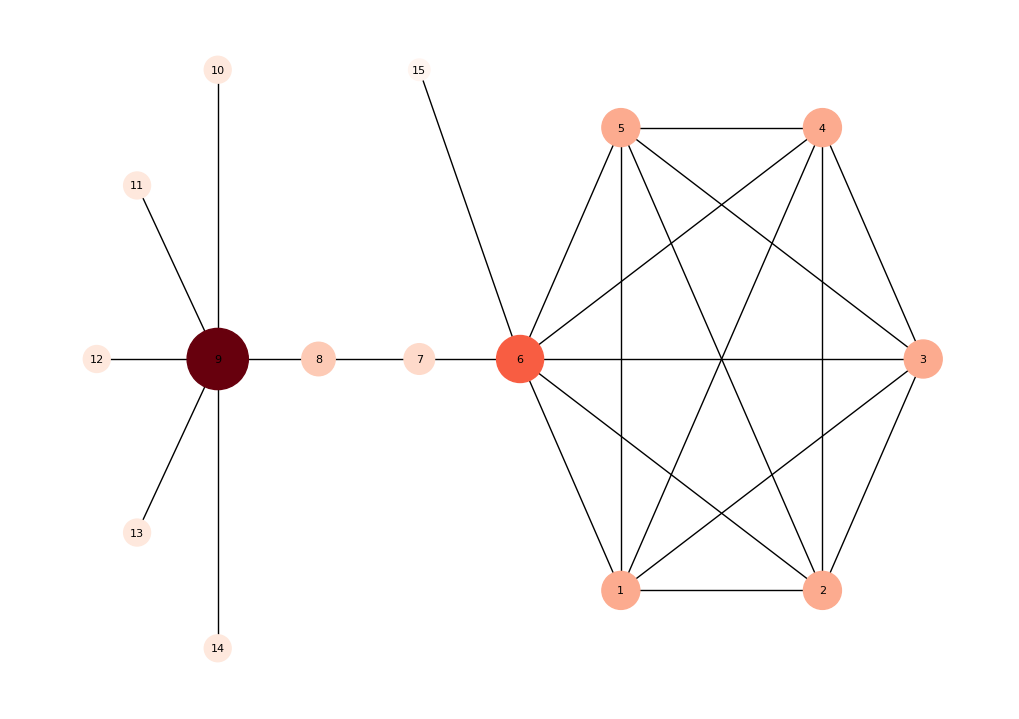

In [24]:
plt.figure(1, figsize=(10,7))
nx.draw(G2,pos,
          with_labels=True,
          nodelist=list(zb_dict.keys()),
          # node size is proportional to eigenvector centrality
          node_size = [d*10000 for d in list(zb_dict.values())],  
          node_color=list(zb_dict.values()),
          font_size=8,
          cmap=plt.cm.Reds,
          )
plt.show()

### (c)


Theory

### (d)

Beta = 0


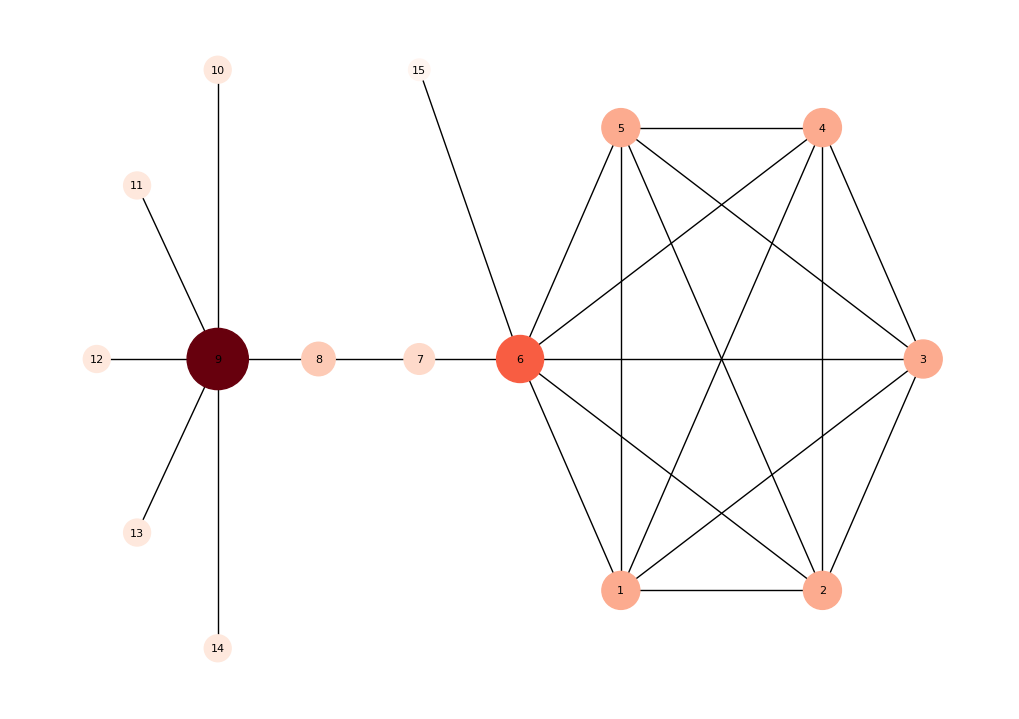

{1: 0.10416663988114633, 2: 0.10416663988114633, 3: 0.10416663988114633, 4: 0.10416663988114633, 5: 0.10416663988114633, 6: 0.14583361041275839, 15: 0.02083329135728212, 7: 0.04166624557894339, 8: 0.041667410927764895, 9: 0.1249969367645338, 10: 0.02083386111059865, 11: 0.02083386111059865, 12: 0.02083386111059865, 13: 0.02083386111059865, 14: 0.02083386111059865}
Beta = 0.25


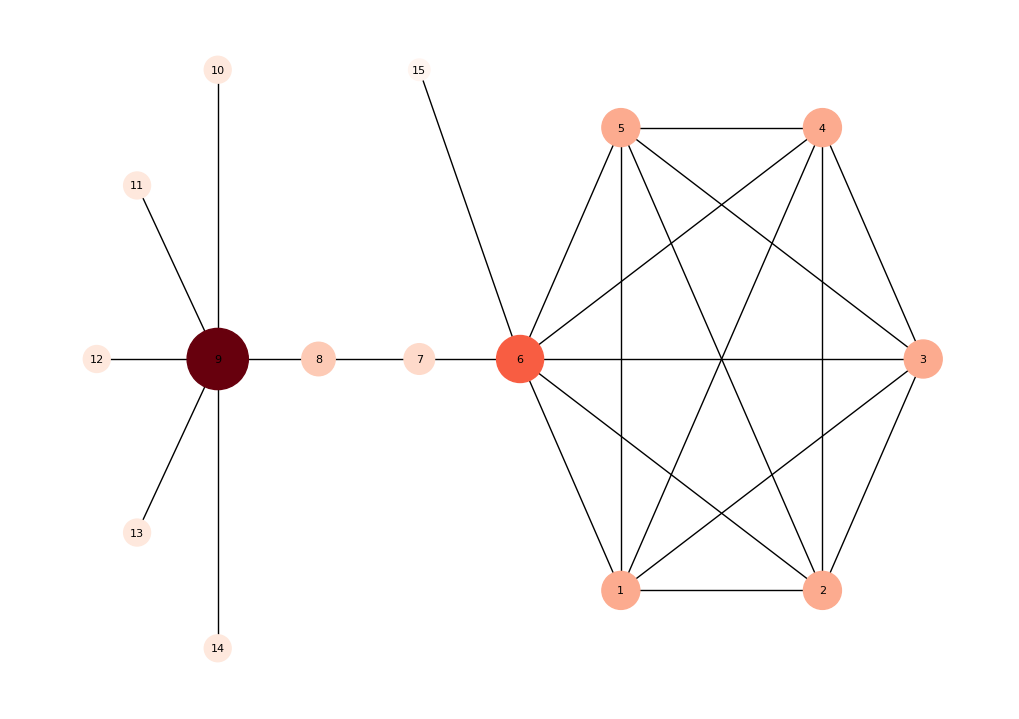

{1: 0.07129284603898198, 2: 0.07129284603898198, 3: 0.07129284603898198, 4: 0.07129284603898198, 5: 0.07129284603898198, 6: 0.11060425318885156, 15: 0.028517168947036497, 7: 0.05088111321631002, 8: 0.05963598771598751, 9: 0.1911181326334736, 10: 0.040555822820686156, 11: 0.040555822820686156, 12: 0.040555822820686156, 13: 0.040555822820686156, 14: 0.040555822820686156}
Beta = 0.5


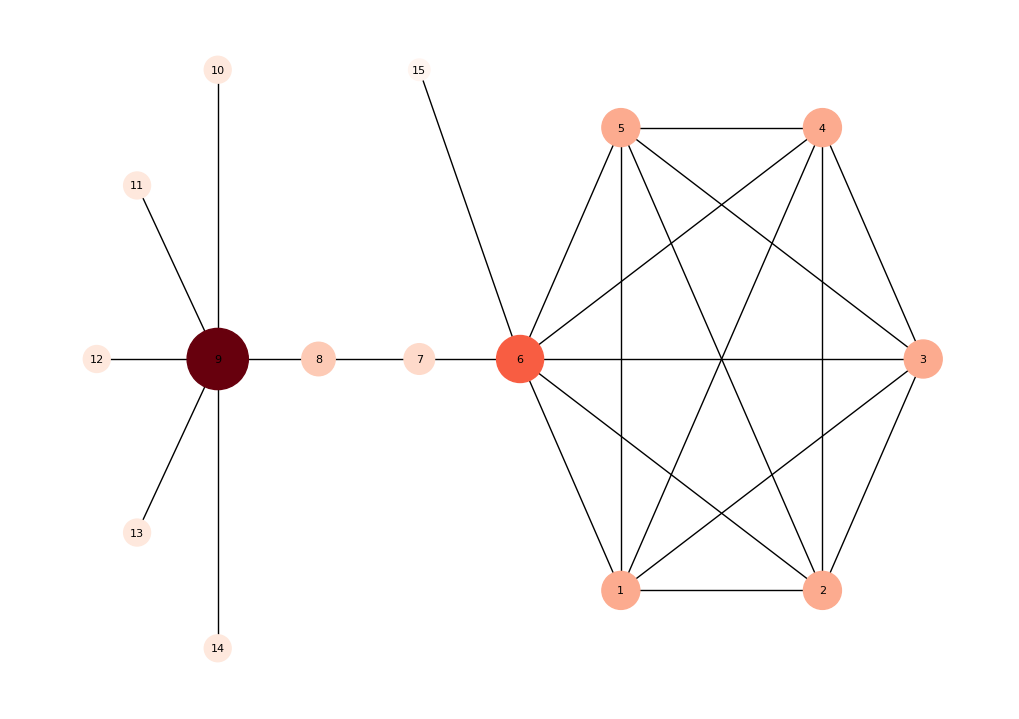

{1: 0.06762745211518431, 2: 0.06762745211518431, 3: 0.06762745211518431, 4: 0.06762745211518431, 5: 0.06762745211518431, 6: 0.10140378672204545, 15: 0.040576497266328025, 7: 0.05587500716441873, 8: 0.06119261276354816, 9: 0.1666945316023872, 10: 0.047224060781070165, 11: 0.047224060781070165, 12: 0.047224060781070165, 13: 0.047224060781070165, 14: 0.047224060781070165}
Beta = 0.75


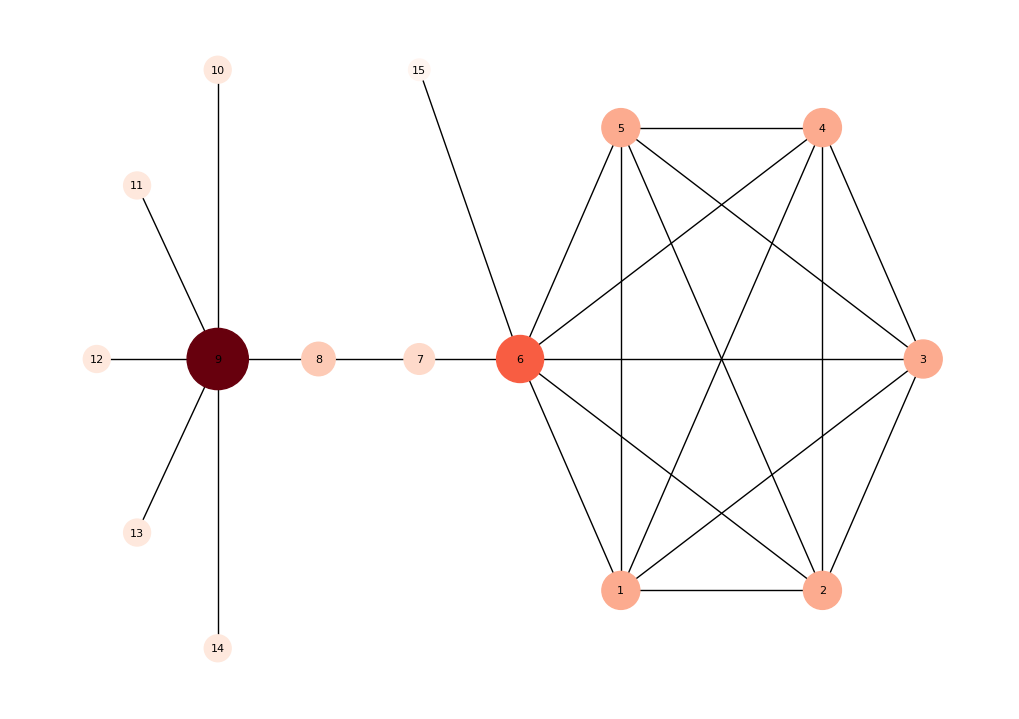

{1: 0.06640653756030798, 2: 0.06640653756030798, 3: 0.06640653756030798, 4: 0.06640653756030798, 5: 0.06640653756030798, 6: 0.08750668778291992, 15: 0.05312522910457583, 7: 0.060989452288183234, 8: 0.06291459626219345, 9: 0.12697705298002854, 10: 0.05529085875611184, 11: 0.05529085875611184, 12: 0.05529085875611184, 13: 0.05529085875611184, 14: 0.05529085875611184}
Beta = 1.0


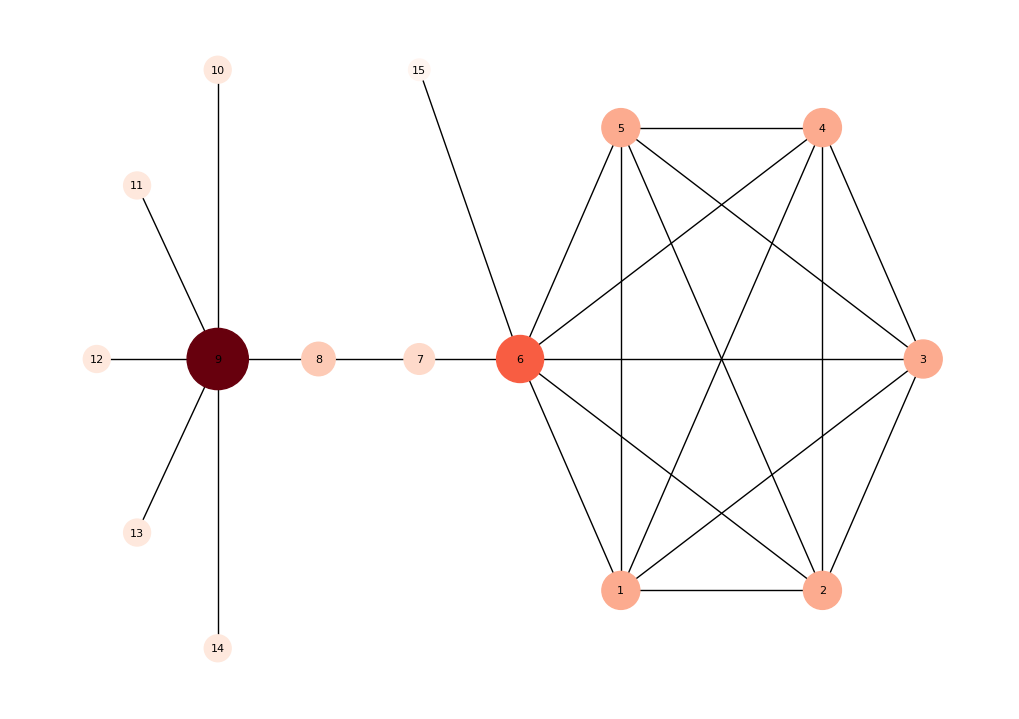

{1: 0.06666666666666667, 2: 0.06666666666666667, 3: 0.06666666666666667, 4: 0.06666666666666667, 5: 0.06666666666666667, 6: 0.06666666666666667, 15: 0.06666666666666667, 7: 0.06666666666666667, 8: 0.06666666666666667, 9: 0.06666666666666667, 10: 0.06666666666666667, 11: 0.06666666666666667, 12: 0.06666666666666667, 13: 0.06666666666666667, 14: 0.06666666666666667}


In [25]:
dict_zb = {}
for beta in [0, 0.25, 0.5, 0.75, 1.0]:
    print("Beta =", beta)
    zb2_dict = nx.algorithms.link_analysis.pagerank_alg.pagerank(G2, alpha=1-beta, max_iter=500)
    dict_zb[beta] = zb2_dict
    plt.figure(1, figsize=(10,7))
    nx.draw(G2,
            pos,
            with_labels=True,
            nodelist=list(zb_dict.keys()),
            # node size is proportional to eigenvector centrality
            node_size = [d*10000 for d in list(zb_dict.values())],  
            node_color=list(zb_dict.values()),
            font_size=8,
            cmap=plt.cm.Reds,
            )
    plt.show()
    print(zb2_dict)

In [27]:
import pandas as pd

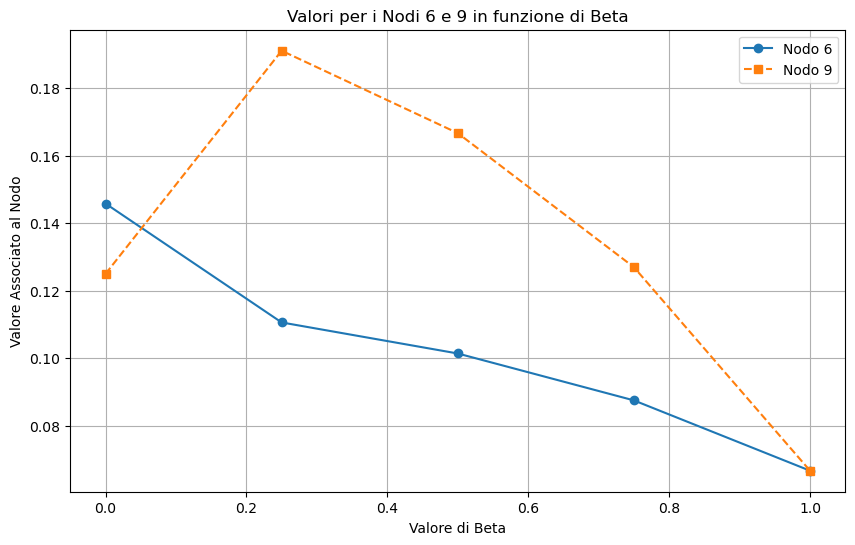

In [29]:
df = pd.DataFrame.from_dict(dict_zb, orient='index')
df.index.name = 'Beta'

# 2. Plotting dei dati
plt.figure(figsize=(10, 6))

# Plot del Nodo 6 (usa l'indice del DataFrame per l'asse X)
plt.plot(df.index, df[6], marker='o', linestyle='-', label='Nodo 6')

# Plot del Nodo 9
plt.plot(df.index, df[9], marker='s', linestyle='--', label='Nodo 9')

plt.title('Valori per i Nodi 6 e 9 in funzione di Beta')
plt.xlabel('Valore di Beta')
plt.ylabel('Valore Associato al Nodo')
plt.grid(True)
plt.legend()

plt.show()

In [158]:
# solo a zero n6 è più grande di n9

#### try deeply

In [157]:
for beta in range(0, 11, 1):
    beta = beta / 10
    print("Beta =", beta)
    zb2_dict = nx.algorithms.link_analysis.pagerank_alg.pagerank(G2, alpha=1-beta, max_iter=500)
    print(zb2_dict)


Beta = 0.0
{1: 0.10416663988114633, 2: 0.10416663988114633, 3: 0.10416663988114633, 4: 0.10416663988114633, 5: 0.10416663988114633, 6: 0.14583361041275839, 15: 0.02083329135728212, 7: 0.04166624557894339, 8: 0.041667410927764895, 9: 0.1249969367645338, 10: 0.02083386111059865, 11: 0.02083386111059865, 12: 0.02083386111059865, 13: 0.02083386111059865, 14: 0.02083386111059865}
Beta = 0.1
{1: 0.07777719500628973, 2: 0.07777719500628973, 3: 0.07777719500628973, 4: 0.07777719500628973, 5: 0.07777719500628973, 6: 0.11752998342314219, 15: 0.021777588677988177, 7: 0.04725225464621295, 8: 0.05661188430119433, 9: 0.1912024145850841, 10: 0.035347979866985964, 11: 0.035347979866985964, 12: 0.035347979866985964, 13: 0.035347979866985964, 14: 0.035347979866985964}
Beta = 0.2
{1: 0.07270449251708737, 2: 0.07270449251708737, 3: 0.07270449251708737, 4: 0.07270449251708737, 5: 0.07270449251708737, 6: 0.1123528289316795, 15: 0.02617360204075849, 7: 0.04979167737370553, 8: 0.059046397987046, 9: 0.19346578

# Exercise 3

In [2]:
try:
    f = sio.loadmat('flow.mat')["flow"].reshape(28,)
    C = sio.loadmat('capacities.mat')["capacities"].reshape(28,)
    B = sio.loadmat('traffic.mat')["traffic"]
    l = sio.loadmat('traveltime.mat')["traveltime"].reshape(28,)

except FileNotFoundError:
    print("Check that the .mat files are in the current directory")
    exit()


#Graph costruction
G3 = nx.DiGraph()
num_nodes, num_links = B.shape

#For each link
for j in range(num_links):
    col_j = B[:, j]

    #Identify the TAIL node
    tail_node = np.where(col_j == 1)[0][0] + 1

    #Identify the HEAD node
    head_node = np.where(col_j == -1)[0][0] +1 

    G3.add_edge(
        tail_node, 
        head_node, 

        # Adding attributes
        capacity=int(C[j]),
        weight=l[j]
    )

print(f"Graph construction completed:\n{G3.number_of_nodes()} nodes and {G3.number_of_edges()} edges")

Graph construction completed:
17 nodes and 28 edges


#### Draw the graph

In [3]:
pos = {
    1: (0, 7.5),   # Santa Monica
    2: (3.5, 7.5),
    3: (6, 7.5),   # Los Angeles
    4: (8.5, 7.5),
    5: (13, 7.5),
    6: (1.5, 5.5), # LAX
    7: (3.5, 5.5),
    8: (6, 5.5),
    9: (8.5, 5.5), # Norwalk
    10: (3.5, 3.5),
    11: (6, 3.5),
    12: (8.5, 3.5),
    13: (11, 3.5),
    14: (13, 3.5),
    15: (6, 1.5),  # Long Beach
    16: (8.5, 1.5),
    17: (12.5, 1.5)
}

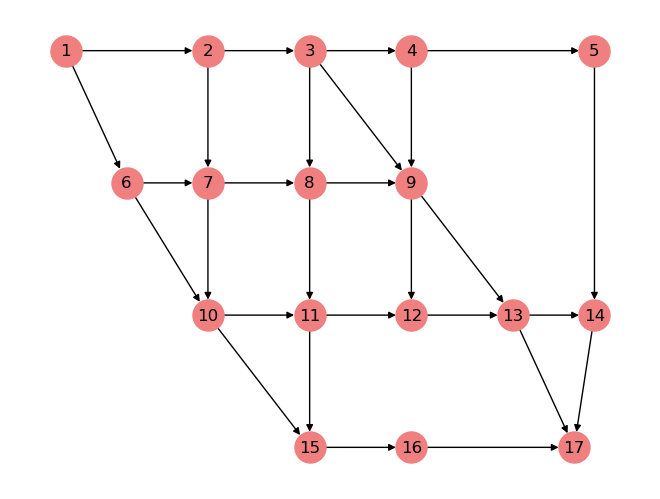

In [4]:
nx.draw(G3, pos, with_labels=True, node_color='lightcoral', node_size=500)
plt.show()

### (a) Shortest path

In [5]:
shortest_path = nx.shortest_path(G3, 1, 17, weight='weight')
      
stringhe_elementi = [str(x) for x in shortest_path]

# Unisci gli elementi con una freccia o una virgola
percorso_formattato = " -> ".join(stringhe_elementi)

print("Shortest path from node 1 to node 17:")
print(percorso_formattato)

Shortest path from node 1 to node 17:
1 -> 2 -> 3 -> 9 -> 13 -> 17


### (b) Maximum flow

In [6]:
maxFlow = nx.algorithms.flow.maximum_flow(G3, 1, 17)
print("Maximum Flow from node 1 to node 17:", maxFlow[0])

Maximum Flow from node 1 to node 17: 22448


### (c) Compute $Bf = ν$

In [7]:
nu = B @ f
print(nu)

[ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


### (d) Social Optimum $f^*$

In [8]:
# by construcion
v = np.zeros(len(nu))
v[0] = nu[0]
v[-1] = -nu[0]

In [9]:
# problem data
n_edges = B.shape[1]
print(n_edges)

28


In [19]:
# Construct the problem
f_ = cp.Variable(n_edges)

cost_function_ = []

for el in range(n_edges):
    cost_function_.append(
        cp.multiply(l[el] * C[el], cp.inv_pos(1 - (f_[el] / C[el]))) - l[el] * C[el]
    )

objective = cp.Minimize(cp.sum(cost_function_))

constraints = [B @ f_ == v, f_ >= 0, f_ <= C]

prob = cp.Problem(objective, constraints)

# The optimal objective value
cost_opt = prob.solve(solver=cp.SCS)

# Flow at social optimum
opt_flow = f_.value

print("Social optimal flow:", opt_flow)
print("\n Optimal cost:", cost_opt)
print("\n")

Social optimal flow: [ 6.53437100e+03  5.79454954e+03  3.04089049e+03  3.04089049e+03
  1.02716290e+04  4.69084601e+03  3.06781792e+03  2.57927070e+03
  3.09952789e+03  7.39821461e+02  2.85456544e-07  2.75365906e+03
  1.40826126e-07  3.04089049e+03  5.58078299e+03  2.88988991e+03
  5.05374262e+03  2.36284955e+03  4.88547227e+02  2.23340186e+03
  3.37843714e+03  5.61183900e+03  2.37324132e+03 -3.15033919e-07
  6.33812558e+03  5.41413180e+03  5.05374262e+03  5.05374262e+03]

 Optimal cost: 26145.183288819506




c:\Users\Utente\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### (e) Wardrop equilibrium $f^{(0)}$

In [23]:
# Construct the problem
f_ = cp.Variable(n_edges)

cost_function_ = 0

integral_e = - cp.multiply(C * l, (cp.log(1 - cp.multiply(f_, cp.inv_pos(C)))))


objective = cp.Minimize(cp.sum(integral_e))

constraints = [B @ f_ == v, f_ >= 0, f_ <= C]

prob = cp.Problem(objective, constraints)

# The optimal objective value
cost_war = prob.solve(solver=cp.SCS)

# Flow at Wardrop equilibrium
wardrop_flow = f_.value

social_cost_at_wardrop = np.sum((l * C) / (1 - wardrop_flow / C) - (l * C))

print("Wardrop equilibrium:", wardrop_flow)
print("\n")
print("Wardrop equilibrium:", cost_war)
print("Social cost at wardrop:", social_cost_at_wardrop)

Wardrop equilibrium: [ 6.45711087e+03  6.25929219e+03  2.19489710e+03  2.19489710e+03
  1.03488891e+04  4.74508109e+03  2.85853642e+03  2.23862562e+03
  3.34479442e+03  1.97818684e+02  2.07709471e-01  4.06418738e+03
  2.00567835e-07  2.19489710e+03  5.60380804e+03  2.35825376e+03
  5.32991764e+03  2.08436335e+03  6.20118505e+02  2.95801858e+03
  2.97837226e+03  5.93639084e+03  2.52813281e+03 -4.75979468e-07
  6.75305246e+03  4.72302991e+03  5.32991763e+03  5.32991763e+03]


Wardrop equilibrium: 15734.703005793499
Social cost at wardrop: 26510.422674751662


c:\Users\Utente\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [24]:
price_of_anarchy = social_cost_at_wardrop / cost_opt
print(f"Price of Anarchy (over Comp): {price_of_anarchy}")

Price of Anarchy (over Comp): 1.0139696624765429


### (f) Tolls  
$\int_{0}^{f_l} t_l(x) \, dx \to \left[ - C_l \cdot t_l \cdot \ln \left( 1 - \frac{f_l}{C_l} \right) + \omega_l \cdot f_l \right]$  

minimizing: $\sum_{l \in L} \left[ - C_l \cdot t_l \cdot \ln \left( 1 - \frac{f_l}{C_l} \right) + \omega_l \cdot f_l \right]$

In [21]:
# Construct the problem
f_ = cp.Variable(n_edges)

#tolls
omega = opt_flow * C * l / (C - opt_flow) ** 2

cost_function_ = 0

for el in range(n_edges):
    integral_e = - cp.multiply(C[el] * l[el], (cp.log(1 - f_[el] / C[el])))
    cost_function_ += integral_e + omega[el] * f_[el]


objective = cp.Minimize(cp.sum(cost_function_))

constraints = [B @ f_ == v, f_ >= 0, f_ <= C]

prob = cp.Problem(objective, constraints)

# The optimal objective value
cost_toll = prob.solve(solver=cp.SCS)

# The social optimal value for f
flow_toll = f_.value

social_cost_tolling = np.sum((l * C) / (1 - flow_toll / C) - (l * C))
print("Tolling optimal flow:", flow_toll)
print("Optimal cost:", cost_toll)
print("Tolling Equilibrium's Total Delay:", social_cost_tolling)

Tolling optimal flow: [ 6.79050832e+03  5.85582178e+03  3.05925716e+03  3.05925716e+03
  1.00154917e+04  4.54030229e+03  3.04720189e+03  2.62806109e+03
  3.10698386e+03  9.34686544e+02 -1.28672249e-07  2.79656462e+03
  1.63328531e-07  3.05925716e+03  5.47518939e+03  2.89601026e+03
  5.00696608e+03  2.42778694e+03  4.19140796e+02  2.31764185e+03
  3.31515105e+03  5.63279291e+03  2.37459173e+03 -6.30836072e-07
  6.36518504e+03  5.43384889e+03  5.00696608e+03  5.00696608e+03]
Optimal cost: 62986.95491811877
Tolling Equilibrium's Total Delay: 26243.617041978385


In [22]:
price_of_anarchy = social_cost_tolling / cost_opt
print(f"Price of Anarchy (over Comp): {price_of_anarchy}")

Price of Anarchy (over Comp): 1.0037648905372551


### (g)

#### Social optimum $f^*$

In [51]:
# Construct the problem
f_ = cp.Variable(n_edges)

cost_function_ = []


for el in range(n_edges):
    cost_function_.append(
        cp.multiply(l[el] * C[el], cp.inv_pos(1 - (f_[el] / C[el]))) - l[el] * C[el] - cp.multiply(f_[el], l[el])
    )

objective = cp.Minimize(cp.sum(cost_function_))

constraints = [B @ f_ == v, f_ >= 0, f_ <= C]

prob = cp.Problem(objective, constraints)

# The optimal objective value
f_star = prob.solve(solver=cp.SCS)

# The social optimal value for f
opt_flow = f_.value

print("Social optimal flow:", f_star)
print("Optimal cost:", cost_opt)

Social optimal flow: 16357.280197559849
Optimal cost: 62986.95491811877


#### Wardrop equilibrium $f^{(w^*)}$

In [52]:
# Construct the problem
f_ = cp.Variable(n_edges)

#tolls
omega = (f_star * C * l / (C - f_star) ** 2 )

cost_function_ = 0

for el in range(n_edges):
    integral_e = - cp.multiply(C[el] * l[el], (cp.log(1 - f_[el] / C[el])))
    cost_function_ += integral_e #+ omega[el] * f_[el]

objective = cp.Minimize(cp.sum(cost_function_))

constraints = [B @ f_ == v, f_ >= 0, f_ <= C]

prob = cp.Problem(objective, constraints)

# The optimal objective value
cost_opt = prob.solve(solver=cp.SCS)

# The social optimal value for f
wardrop = f_.value

print("Wardrop equilibrium with tolls:", wardrop)

Wardrop equilibrium with tolls: [ 6.45711087e+03  6.25929219e+03  2.19489710e+03  2.19489710e+03
  1.03488891e+04  4.74508109e+03  2.85853642e+03  2.23862562e+03
  3.34479442e+03  1.97818684e+02  2.07709471e-01  4.06418738e+03
  2.00567835e-07  2.19489710e+03  5.60380804e+03  2.35825376e+03
  5.32991764e+03  2.08436335e+03  6.20118505e+02  2.95801858e+03
  2.97837226e+03  5.93639084e+03  2.52813281e+03 -4.75979468e-07
  6.75305246e+03  4.72302991e+03  5.32991763e+03  5.32991763e+03]


In [ ]:
if np.allclose(wardrop, f_star):
    print("The Wardrop equilibrium with tolls matches the social optimum")
else:
    print("The Wardrop equilibrium with tolls does NOT match the social optimum")

The Wardrop equilibrium with tolls does NOT match the social optimum
